In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 11.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_9129/707780074.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


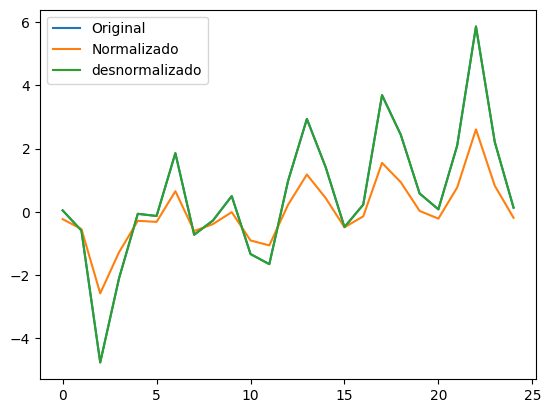

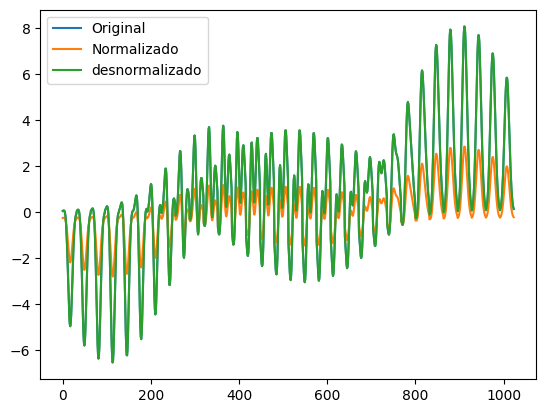

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-23 22:21:45.458193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 22:21:45.458304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 22:21:45.721733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 22:21:46.158067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 22:21:49.244399: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [7]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.1,
            hidden_sizes = [[10], [11], [12], [13], [14], [15]],
            regularizers=[0.01, 0.07],
            learning_rate=[0.03, 0.05])

Testando combinacao1: Hidden Size=[10], regularizer=0.01, learning_rate=0.03
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
++

2024-10-23 22:25:25.989249: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.985206,0.812480,0.969559,0.974588,0.973852,0.098928,1.253944,0.164775,0.200396,0.182586,0.379809,0.314528,1.020886,0.327918,86.626733,136.600641
model_2_5_1,0.985460,0.811864,0.968924,0.973230,0.972839,0.097232,1.258065,0.168214,0.211099,0.189656,0.371901,0.311820,1.020528,0.325095,86.661318,136.635226
model_2_5_2,0.985664,0.811239,0.968302,0.971908,0.971851,0.095867,1.262245,0.171581,0.221527,0.196554,0.364261,0.309625,1.020240,0.322806,86.689579,136.663488
model_2_5_3,0.985824,0.810609,0.967694,0.970623,0.970890,0.094794,1.266456,0.174872,0.231663,0.203268,0.356904,0.307886,1.020013,0.320994,86.712099,136.686008
model_2_5_4,0.985947,0.809979,0.967101,0.969375,0.969955,0.093975,1.270670,0.178082,0.241503,0.209793,0.349832,0.306554,1.019840,0.319605,86.729445,136.703354
model_2_5_5,0.986036,0.809351,0.966523,0.968165,0.969049,0.093379,1.274868,0.181208,0.251041,0.216124,0.343034,0.305580,1.019714,0.318589,86.742174,136.716083
model_2_5_6,0.986096,0.808729,0.965962,0.966995,0.968170,0.092976,1.279029,0.184247,0.260270,0.222259,0.336514,0.304920,1.019629,0.317901,86.750819,136.724728
model_2_5_7,0.986131,0.808115,0.965417,0.965863,0.967320,0.092742,1.283139,0.187198,0.269193,0.228195,0.330266,0.304535,1.019580,0.317500,86.755873,136.729781
model_2_5_8,0.986144,0.807510,0.964888,0.964771,0.966498,0.092653,1.287185,0.190060,0.277809,0.233935,0.324282,0.304389,1.019561,0.317348,86.757794,136.731703
model_2_5_9,0.986139,0.806916,0.964376,0.963717,0.965705,0.092688,1.291155,0.192831,0.286119,0.239475,0.318556,0.304447,1.019568,0.317408,86.757030,136.730939


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_15,0.990200,0.810448,0.950717,0.969749,0.981907,0.065534,1.267533,0.078496,0.225774,0.152135,0.190040,0.255995,1.013836,0.266894,87.450384,137.424292
model_2_6_16,0.989971,0.810443,0.946458,0.968002,0.980729,0.067063,1.267571,0.085279,0.238808,0.162044,0.186827,0.258965,1.014158,0.269989,87.404256,137.378165
model_2_6_14,0.990406,0.810427,0.954972,0.971516,0.983094,0.064158,1.267679,0.071719,0.212585,0.142152,0.193430,0.253294,1.013545,0.264078,87.492814,137.466722
model_2_6_17,0.989724,0.810413,0.942213,0.966282,0.979563,0.068717,1.267768,0.092040,0.251644,0.171842,0.183776,0.262138,1.014507,0.273298,87.355530,137.329439
model_2_6_13,0.990584,0.810373,0.959197,0.973299,0.984286,0.062967,1.268037,0.064989,0.199280,0.132135,0.196996,0.250933,1.013294,0.261616,87.530277,137.504186
model_2_6_18,0.989462,0.810363,0.938002,0.964592,0.978415,0.070470,1.268101,0.098747,0.264257,0.181502,0.180879,0.265462,1.014878,0.276764,87.305127,137.279036
model_2_6_19,0.989188,0.810296,0.933839,0.962936,0.977285,0.072302,1.268549,0.105379,0.276618,0.190998,0.178128,0.268890,1.015264,0.280337,87.253808,137.227717
model_2_6_12,0.990729,0.810283,0.963367,0.975090,0.985476,0.061998,1.268641,0.058347,0.185909,0.122128,0.200756,0.248993,1.013089,0.259593,87.561318,137.535226
model_2_6_20,0.988905,0.810215,0.929736,0.961316,0.976178,0.074192,1.269093,0.111913,0.288707,0.200310,0.175520,0.272382,1.015663,0.283978,87.202196,137.176104
model_2_6_11,0.990835,0.810150,0.967451,0.976883,0.986658,0.061289,1.269527,0.051843,0.172527,0.112185,0.204719,0.247567,1.012939,0.258106,87.584297,137.558206


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.988780,0.809839,0.999837,0.989758,0.993515,0.075030,1.271609,0.000709,0.108584,0.054646,0.159403,0.273916,1.015840,0.285577,87.179738,137.153646
model_2_7_1,0.989673,0.809799,0.999441,0.990129,0.993646,0.069058,1.271873,0.002425,0.104652,0.053539,0.194626,0.262788,1.014580,0.273976,87.345623,137.319532
model_2_7_2,0.990430,0.809682,0.998792,0.990390,0.993643,0.063998,1.272657,0.005242,0.101886,0.053564,0.227914,0.252978,1.013511,0.263748,87.497809,137.471718
model_2_7_3,0.991065,0.809498,0.997926,0.990555,0.993524,0.059747,1.273887,0.008997,0.100144,0.054571,0.259528,0.244433,1.012614,0.254839,87.635260,137.609169
model_2_7_4,0.991593,0.809257,0.996878,0.990634,0.993304,0.056214,1.275497,0.013546,0.099299,0.056423,0.289406,0.237096,1.011868,0.247190,87.757163,137.731072
model_2_7_5,0.992027,0.808969,0.995676,0.990640,0.992998,0.053316,1.277427,0.018760,0.099237,0.058999,0.317661,0.230904,1.011256,0.240734,87.863020,137.836929
model_2_7_6,0.992376,0.808640,0.994347,0.990582,0.992619,0.050979,1.279625,0.024526,0.099854,0.062190,0.344372,0.225785,1.010763,0.235397,87.952685,137.926594
model_2_7_7,0.992652,0.808278,0.992913,0.990468,0.992179,0.049135,1.282045,0.030744,0.101056,0.065900,0.369627,0.221665,1.010373,0.231101,88.026357,138.000265
model_2_7_8,0.992863,0.807889,0.991397,0.990308,0.991687,0.047726,1.284645,0.037324,0.102760,0.070042,0.393517,0.218462,1.010076,0.227762,88.084578,138.058487
model_2_7_9,0.993017,0.807479,0.989815,0.990107,0.991154,0.046696,1.287389,0.044187,0.104890,0.074539,0.416117,0.216094,1.009859,0.225293,88.128176,138.102085


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.993816,0.801235,0.997102,0.935031,0.992772,0.041352,1.329145,0.039844,0.068379,0.054111,0.573476,0.203352,1.008730,0.212009,88.371263,138.345171
model_2_8_1,0.994124,0.801204,0.996763,0.937777,0.992654,0.039290,1.329347,0.044509,0.065489,0.054999,0.558757,0.198218,1.008295,0.206656,88.473556,138.447465
model_2_8_2,0.994384,0.801144,0.996396,0.940312,0.992495,0.037554,1.329748,0.049556,0.062821,0.056188,0.544787,0.193789,1.007928,0.202039,88.563946,138.537854
model_2_8_3,0.994601,0.801059,0.996007,0.942653,0.992302,0.036106,1.330317,0.054906,0.060357,0.057632,0.531527,0.190015,1.007623,0.198105,88.642601,138.616510
model_2_8_4,0.994779,0.800953,0.995601,0.944815,0.992081,0.034911,1.331027,0.060489,0.058081,0.059285,0.518941,0.186846,1.007371,0.194800,88.709882,138.683791
model_2_8_5,0.994924,0.800830,0.995182,0.946815,0.991837,0.033940,1.331854,0.066245,0.055977,0.061111,0.506995,0.184229,1.007166,0.192072,88.766302,138.740211
model_2_8_6,0.995040,0.800692,0.994755,0.948663,0.991575,0.033165,1.332777,0.072120,0.054031,0.063075,0.495659,0.182114,1.007002,0.189867,88.812493,138.786402
model_2_8_7,0.995130,0.800542,0.994323,0.950374,0.991298,0.032563,1.333777,0.078069,0.052231,0.065150,0.484898,0.180451,1.006875,0.188133,88.849178,138.823087
model_2_8_8,0.995198,0.800383,0.993887,0.951958,0.991010,0.032110,1.334840,0.084051,0.050564,0.067307,0.474684,0.179193,1.006779,0.186822,88.877157,138.851066
model_2_8_9,0.995246,0.800217,0.993452,0.953424,0.990713,0.031789,1.335951,0.090033,0.049020,0.069527,0.464989,0.178295,1.006711,0.185886,88.897259,138.871168


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_20,0.991973,0.809188,0.982365,0.972977,0.974665,0.053679,1.275963,0.033659,0.277679,0.155669,0.261201,0.231688,1.011333,0.241552,87.849453,137.823362
model_2_9_21,0.991714,0.809183,0.981549,0.971847,0.973594,0.055408,1.275992,0.035215,0.289290,0.162253,0.256665,0.235389,1.011698,0.245410,87.786067,137.759976
model_2_9_19,0.992238,0.809179,0.983195,0.974160,0.975783,0.051901,1.276022,0.032074,0.265528,0.148801,0.265860,0.227818,1.010957,0.237517,87.916827,137.890736
model_2_9_22,0.991464,0.809168,0.980750,0.970769,0.972568,0.057084,1.276095,0.036741,0.300371,0.168556,0.252269,0.238922,1.012052,0.249093,87.726478,137.700387
model_2_9_18,0.992511,0.809154,0.984039,0.975395,0.976947,0.050077,1.276185,0.030464,0.252832,0.141648,0.270653,0.223780,1.010572,0.233307,87.988372,137.962281
model_2_9_23,0.991221,0.809144,0.979968,0.969741,0.971587,0.058705,1.276258,0.038233,0.310933,0.174583,0.248014,0.242290,1.012394,0.252605,87.670475,137.644383
model_2_9_24,0.990987,0.809112,0.979205,0.968762,0.970650,0.060269,1.276470,0.039689,0.320991,0.180340,0.243895,0.245498,1.012724,0.255949,87.617869,137.591778
model_2_9_17,0.992790,0.809111,0.984893,0.976683,0.978157,0.048214,1.276472,0.028833,0.239595,0.134214,0.275561,0.219577,1.010179,0.228925,88.064202,138.038111
model_2_9_16,0.993073,0.809046,0.985756,0.978024,0.979412,0.046319,1.276907,0.027186,0.225821,0.126503,0.280583,0.215217,1.009779,0.224380,88.144428,138.118336
model_2_9_15,0.993360,0.808956,0.986626,0.979414,0.980710,0.044401,1.277515,0.025527,0.211530,0.118528,0.285705,0.210714,1.009374,0.219685,88.229007,138.202915


DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[10], regularizer=0.07, learning_rate=0.03
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

2024-10-23 22:28:44.768838: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 11 +++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_6_0,0.985166,0.805444,0.722547,0.995654,0.973457,0.099196,1.300999,0.352469,0.047113,0.199791,0.392089,0.314954,1.016953,0.328363,94.621310,149.470722
model_7_6_1,0.985313,0.805340,0.717368,0.995626,0.973000,0.098213,1.301691,0.359047,0.047410,0.203229,0.401519,0.313390,1.016785,0.326731,94.641231,149.490643
model_7_6_2,0.985442,0.805225,0.712235,0.995597,0.972546,0.097347,1.302463,0.365569,0.047725,0.206647,0.410760,0.312004,1.016637,0.325287,94.658953,149.508365
model_7_6_3,0.985556,0.805099,0.707153,0.995567,0.972095,0.096588,1.303307,0.372025,0.048055,0.210040,0.419809,0.310786,1.016508,0.324017,94.674600,149.524012
model_7_6_4,0.985654,0.804963,0.702127,0.995535,0.971648,0.095929,1.304215,0.378409,0.048401,0.213405,0.428659,0.309725,1.016395,0.322910,94.688286,149.537698
model_7_6_5,0.985739,0.804819,0.697162,0.995502,0.971205,0.095363,1.305179,0.384717,0.048760,0.216738,0.437310,0.308809,1.016298,0.321956,94.700130,149.549542
model_7_6_6,0.985811,0.804667,0.692262,0.995468,0.970767,0.094882,1.306192,0.390942,0.049130,0.220036,0.445760,0.308029,1.016216,0.321142,94.710248,149.559660
model_7_6_7,0.985871,0.804509,0.687430,0.995433,0.970334,0.094479,1.307249,0.397080,0.049511,0.223295,0.454008,0.307374,1.016147,0.320460,94.718758,149.568171
model_7_6_8,0.985921,0.804345,0.682672,0.995397,0.969907,0.094148,1.308343,0.403125,0.049902,0.226513,0.462055,0.306836,1.016091,0.319898,94.725770,149.575182
model_7_6_9,0.985960,0.804177,0.677987,0.995360,0.969485,0.093884,1.309469,0.409076,0.050300,0.229689,0.469897,0.306405,1.016046,0.319450,94.731384,149.580796


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_7_24,0.987391,0.806440,0.607987,0.951990,0.796322,0.084314,1.294333,0.447946,0.049731,0.248839,0.268299,0.290368,1.014410,0.302730,94.946418,149.795830
model_7_7_23,0.987404,0.806398,0.609401,0.952728,0.797296,0.084227,1.294620,0.446331,0.048968,0.247649,0.275039,0.290220,1.014395,0.302575,94.948468,149.797880
model_7_7_22,0.987415,0.806351,0.610846,0.953438,0.798273,0.084158,1.294934,0.444680,0.048232,0.246456,0.281977,0.290101,1.014383,0.302451,94.950111,149.799523
model_7_7_21,0.987422,0.806299,0.612323,0.954117,0.799252,0.084108,1.295278,0.442992,0.047528,0.245260,0.289122,0.290014,1.014375,0.302360,94.951309,149.800721
model_7_7_20,0.987427,0.806243,0.613833,0.954763,0.800231,0.084078,1.295655,0.441266,0.046860,0.244063,0.296479,0.289963,1.014370,0.302307,94.952010,149.801422
model_7_7_19,0.987428,0.806181,0.615374,0.955368,0.801209,0.084072,1.296066,0.439506,0.046232,0.242869,0.304060,0.289951,1.014368,0.302295,94.952171,149.801583
model_7_7_18,0.987425,0.806114,0.616947,0.955930,0.802183,0.084090,1.296514,0.437708,0.045650,0.241679,0.311863,0.289983,1.014372,0.302328,94.951736,149.801148
model_7_7_17,0.987418,0.806041,0.618554,0.956444,0.803152,0.084135,1.297002,0.435872,0.045118,0.240495,0.319896,0.290061,1.014379,0.302409,94.950659,149.800071
model_7_7_16,0.987407,0.805962,0.620193,0.956903,0.804113,0.084210,1.297532,0.433999,0.044643,0.239321,0.328170,0.290190,1.014392,0.302544,94.948873,149.798285
model_7_7_15,0.987391,0.805876,0.621864,0.957303,0.805064,0.084318,1.298107,0.432089,0.044228,0.238159,0.336687,0.290375,1.014410,0.302737,94.946327,149.795740


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_8_0,0.988058,0.805830,0.997109,0.997725,0.997528,0.079855,1.298416,0.010165,0.005880,0.008023,0.339825,0.282586,1.013648,0.294616,95.055088,149.904500
model_7_8_1,0.988627,0.805147,0.997325,0.995594,0.996797,0.076050,1.302985,0.009407,0.011386,0.010396,0.409682,0.275772,1.012998,0.287512,95.152725,150.002137
model_7_8_2,0.989104,0.804397,0.997421,0.992789,0.995732,0.072861,1.307998,0.009069,0.018636,0.013852,0.477928,0.269927,1.012452,0.281419,95.238412,150.087824
model_7_8_3,0.989495,0.803588,0.997399,0.989359,0.994355,0.070248,1.313409,0.009145,0.027497,0.018321,0.544613,0.265044,1.012006,0.276328,95.311436,150.160848
model_7_8_4,0.989805,0.802725,0.997263,0.985357,0.992688,0.068176,1.319180,0.009626,0.037839,0.023733,0.609780,0.261106,1.011652,0.272222,95.371316,150.220728
model_7_8_5,0.990039,0.801814,0.997014,0.980833,0.990752,0.066608,1.325268,0.010502,0.049532,0.030017,0.673458,0.258085,1.011384,0.269072,95.417865,150.267278
model_7_8_6,0.990204,0.800862,0.996656,0.975835,0.988568,0.065508,1.331638,0.011761,0.062447,0.037104,0.736024,0.255944,1.011196,0.266840,95.451180,150.300592
model_7_8_7,0.990303,0.799873,0.996192,0.970411,0.986158,0.064841,1.338251,0.013391,0.076462,0.044926,0.797283,0.254639,1.011082,0.265480,95.471628,150.321040
model_7_8_8,0.990343,0.798852,0.995627,0.964610,0.983542,0.064576,1.345075,0.015379,0.091454,0.053417,0.857107,0.254118,1.011036,0.264936,95.479833,150.329245
model_7_8_9,0.990328,0.797805,0.994964,0.958474,0.980740,0.064679,1.352076,0.017710,0.107309,0.062509,0.915495,0.254321,1.011054,0.265148,95.476638,150.326050


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_9_0,0.985874,0.780427,0.966472,0.861337,0.973283,0.094461,1.468284,0.289339,0.080809,0.185074,1.634160,0.307344,1.016144,0.320429,94.719146,149.568558
model_7_9_1,0.985630,0.779472,0.964420,0.851859,0.971606,0.096093,1.474672,0.307041,0.086332,0.196686,1.624713,0.309989,1.016423,0.323186,94.684871,149.534284
model_7_9_2,0.985362,0.778516,0.962361,0.842129,0.969914,0.097884,1.481068,0.324814,0.092003,0.208408,1.615755,0.312864,1.016729,0.326183,94.647945,149.497357
model_7_9_3,0.985073,0.777560,0.960299,0.832175,0.968211,0.099815,1.487458,0.342607,0.097804,0.220205,1.607057,0.315935,1.017059,0.329385,94.608876,149.458288


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[11], regularizer=0.07, learning_rate=0.05
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

2024-10-23 22:42:28.588704: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_6_0,0.985270,0.807214,0.604464,0.983977,0.984512,0.098499,1.289160,0.060021,0.158455,0.109238,1.606591,0.313846,1.014141,0.327207,102.635412,162.360327
model_10_6_1,0.986062,0.806283,0.594994,0.983555,0.984114,0.093204,1.295386,0.061458,0.162631,0.112045,1.607169,0.305294,1.013381,0.318291,102.745923,162.470839
model_10_6_2,0.986751,0.805340,0.583025,0.983120,0.983681,0.088593,1.301689,0.063275,0.166930,0.115102,1.607407,0.297645,1.012719,0.310317,102.847410,162.572325
model_10_6_3,0.987350,0.804394,0.568997,0.982678,0.983220,0.084588,1.308021,0.065403,0.171299,0.118352,1.607336,0.290840,1.012144,0.303221,102.939930,162.664846
model_10_6_4,0.987869,0.803448,0.553270,0.982232,0.982738,0.081121,1.314344,0.067790,0.175707,0.121748,1.607016,0.284818,1.011646,0.296944,103.023616,162.748531
model_10_6_5,0.988316,0.802509,0.536175,0.981787,0.982242,0.078132,1.320623,0.070384,0.180114,0.125249,1.606477,0.279521,1.011217,0.291421,103.098707,162.823622
model_10_6_6,0.988700,0.801581,0.517998,0.981344,0.981736,0.075565,1.326832,0.073142,0.184494,0.128818,1.605753,0.274892,1.010848,0.286594,103.165515,162.890430
model_10_6_7,0.989028,0.800666,0.498994,0.980906,0.981224,0.073372,1.332946,0.076026,0.188826,0.132426,1.604879,0.270873,1.010533,0.282405,103.224415,162.949330
model_10_6_8,0.989306,0.799769,0.479371,0.980474,0.980711,0.071510,1.338948,0.079004,0.193091,0.136047,1.603874,0.267413,1.010266,0.278798,103.275837,163.000753
model_10_6_9,0.989541,0.798890,0.459322,0.980051,0.980199,0.069939,1.344823,0.082046,0.197275,0.139661,1.602765,0.264460,1.010041,0.275719,103.320255,163.045170


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_7_24,0.991483,0.813495,0.947580,0.980737,0.979004,0.056952,1.247163,0.084273,0.244210,0.164241,0.573150,0.238646,1.008176,0.248806,103.731090,163.456005
model_10_7_23,0.991689,0.813361,0.950013,0.981341,0.979743,0.055576,1.248054,0.080361,0.236552,0.158457,0.593035,0.235745,1.007979,0.245782,103.780012,163.504927
model_10_7_22,0.991898,0.813210,0.952536,0.981969,0.980512,0.054179,1.249068,0.076306,0.228587,0.152446,0.613961,0.232764,1.007778,0.242673,103.830929,163.555844
model_10_7_21,0.992109,0.813037,0.955145,0.982622,0.981309,0.052766,1.250220,0.072111,0.220308,0.146209,0.635980,0.229708,1.007575,0.239488,103.883778,163.608693
model_10_7_20,0.992322,0.812842,0.957839,0.983300,0.982135,0.051344,1.251528,0.067780,0.211713,0.139747,0.659161,0.226592,1.007371,0.236239,103.938408,163.663324
model_10_7_19,0.992534,0.812620,0.960612,0.984002,0.982989,0.049922,1.253012,0.063322,0.202808,0.133065,0.683547,0.223432,1.007167,0.232944,103.994589,163.719505
model_10_7_18,0.992746,0.812368,0.963459,0.984729,0.983871,0.048509,1.254695,0.058745,0.193594,0.126170,0.709214,0.220247,1.006964,0.229624,104.052016,163.776932
model_10_7_17,0.992954,0.812083,0.966370,0.985479,0.984778,0.047117,1.256601,0.054065,0.184082,0.119074,0.736225,0.217065,1.006764,0.226306,104.110240,163.835155
model_10_7_16,0.993157,0.811760,0.969335,0.986252,0.985709,0.045761,1.258760,0.049299,0.174282,0.111791,0.764658,0.213917,1.006569,0.223024,104.168660,163.893576
model_10_7_15,0.993352,0.811395,0.972338,0.987047,0.986661,0.044456,1.261204,0.044471,0.164212,0.104342,0.794581,0.210847,1.006382,0.219823,104.226496,163.951412


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_8_0,0.992231,0.813310,0.999499,0.918916,0.998974,0.051951,1.248396,0.006587,0.007010,0.006798,0.555587,0.227928,1.007458,0.237631,103.914909,163.639824
model_10_8_1,0.992880,0.813070,0.999347,0.904089,0.998727,0.047615,1.250001,0.008575,0.008292,0.008434,0.538970,0.218208,1.006836,0.227498,104.089225,163.814140
model_10_8_2,0.993439,0.812784,0.999171,0.884612,0.998425,0.043871,1.251917,0.010895,0.009976,0.010435,0.523200,0.209453,1.006298,0.218370,104.253018,163.977934
model_10_8_3,0.993921,0.812459,0.998973,0.861237,0.998077,0.040653,1.254090,0.013490,0.011996,0.012743,0.508228,0.201625,1.005836,0.210209,104.405381,164.130296
model_10_8_4,0.994332,0.812102,0.998759,0.834625,0.997691,0.037902,1.256475,0.016311,0.014297,0.015304,0.494013,0.194685,1.005441,0.202973,104.545487,164.270402
model_10_8_5,0.994681,0.811720,0.998530,0.805357,0.997273,0.035566,1.259029,0.019315,0.016827,0.018071,0.480507,0.188591,1.005106,0.196619,104.672709,164.397624
model_10_8_6,0.994976,0.811318,0.998291,0.773934,0.996831,0.033598,1.261718,0.022463,0.019544,0.021003,0.467678,0.183297,1.004823,0.191101,104.786582,164.511498
model_10_8_7,0.995221,0.810901,0.998043,0.740817,0.996369,0.031954,1.264507,0.025721,0.022407,0.024064,0.455485,0.178758,1.004587,0.186368,104.886893,164.611808
model_10_8_8,0.995424,0.810473,0.997789,0.706393,0.995892,0.030598,1.267371,0.029060,0.025383,0.027222,0.444565,0.174922,1.004393,0.182369,104.973655,164.698571
model_10_8_9,0.995589,0.810037,0.997530,0.671008,0.995406,0.029494,1.270285,0.032454,0.028442,0.030448,0.437968,0.171739,1.004234,0.179051,105.047106,164.772022


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_9_17,0.994030,0.808450,0.988921,0.902701,0.964045,0.039921,1.280897,0.049246,0.176249,0.112748,0.255010,0.199803,1.005731,0.208309,104.441703,164.166618
model_10_9_16,0.994227,0.808445,0.989476,0.907317,0.965772,0.038604,1.280926,0.046781,0.167888,0.107335,0.258874,0.196479,1.005542,0.204844,104.508795,164.233710
model_10_9_18,0.993834,0.808444,0.988380,0.898205,0.962363,0.041234,1.280935,0.051650,0.184394,0.118022,0.251346,0.203062,1.005920,0.211707,104.376968,164.101883
model_10_9_19,0.993639,0.808430,0.987854,0.893833,0.960728,0.042538,1.281031,0.053989,0.192314,0.123151,0.247872,0.206246,1.006107,0.215027,104.314737,164.039652
model_10_9_15,0.994423,0.808429,0.990044,0.912044,0.967539,0.037290,1.281035,0.044257,0.159326,0.101791,0.262951,0.193106,1.005353,0.201327,104.578055,164.302970
model_10_9_20,0.993446,0.808408,0.987343,0.889587,0.959139,0.043826,1.281176,0.056261,0.200005,0.128133,0.244574,0.209347,1.006292,0.218260,104.255039,163.979955
model_10_9_14,0.994618,0.808399,0.990624,0.916876,0.969346,0.035987,1.281234,0.041679,0.150573,0.096126,0.267251,0.189702,1.005166,0.197778,104.649194,164.374109
model_10_9_21,0.993256,0.808380,0.986847,0.885472,0.957599,0.045096,1.281362,0.058465,0.207459,0.132962,0.241449,0.212359,1.006474,0.221400,104.197906,163.922821
model_10_9_13,0.994810,0.808354,0.991214,0.921802,0.971188,0.034704,1.281540,0.039052,0.141649,0.090351,0.271788,0.186290,1.004982,0.194220,104.721810,164.446726
model_10_9_22,0.993069,0.808347,0.986367,0.881487,0.956108,0.046344,1.281582,0.060601,0.214677,0.137639,0.238486,0.215278,1.006653,0.224442,104.143309,163.868225


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[12], regularizer=0.07, learning_rate=0.03
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_12_9_0,0.985347,0.740360,0.910642,0.982803,0.975577,0.097985,1.736214,0.144299,0.099783,0.122041,1.008874,0.313025,1.014067,0.326351,102.645890,162.370805
model_12_9_1,0.985729,0.740218,0.904448,0.981090,0.973582,0.095429,1.737166,0.154301,0.109718,0.132010,0.982780,0.308917,1.013700,0.322068,102.698736,162.423651
model_12_9_2,0.986019,0.740019,0.898099,0.979361,0.971552,0.093491,1.738496,0.164554,0.119753,0.142154,0.957708,0.305763,1.013422,0.318779,102.739786,162.464701
model_12_9_3,0.986229,0.739773,0.891658,0.977625,0.969503,0.092087,1.740140,0.174956,0.129824,0.152390,0.933648,0.303459,1.013220,0.316377,102.770041,162.494957
model_12_9_4,0.986370,0.739488,0.885182,0.975892,0.967451,0.091146,1.742044,0.185413,0.139878,0.162646,0.910588,0.301904,1.013085,0.314757,102.790587,162.515502
model_12_9_5,0.986451,0.739172,0.878717,0.974170,0.965406,0.090604,1.744157,0.195853,0.149872,0.172862,0.888541,0.301005,1.013007,0.313819,102.802515,162.527430
model_12_9_6,0.986481,0.738831,0.872303,0.972465,0.963380,0.090405,1.746438,0.206211,0.159767,0.182989,0.867440,0.300674,1.012979,0.313474,102.806917,162.531832
model_12_9_7,0.986466,0.738470,0.865972,0.970781,0.961379,0.090499,1.748850,0.216434,0.169535,0.192984,0.847257,0.300830,1.012992,0.313637,102.804837,162.529753
model_12_9_8,0.986415,0.738095,0.859750,0.969125,0.959412,0.090842,1.751361,0.226481,0.179146,0.202813,0.827966,0.301401,1.013042,0.314232,102.797261,162.522177
model_12_9_9,0.986332,0.737709,0.853660,0.967499,0.957484,0.091397,1.753944,0.236316,0.188579,0.212447,0.809534,0.302319,1.013121,0.315189,102.785094,162.510009


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[13], regularizer=0.01, learning_rate=0.03
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_18_6_9,0.989131,0.821252,0.977871,0.860097,0.976698,0.072681,1.195291,0.290817,0.044451,0.167634,0.261188,0.269594,1.007905,0.281071,119.243357,188.719279
model_18_6_8,0.988982,0.821237,0.978216,0.866757,0.977160,0.073676,1.195390,0.286284,0.042336,0.164310,0.260496,0.271433,1.008013,0.282988,119.216163,188.692085
model_18_6_10,0.989241,0.821230,0.977507,0.853062,0.976211,0.071945,1.195433,0.295594,0.046687,0.171141,0.261906,0.268226,1.007825,0.279644,119.263708,188.739630
model_18_6_7,0.988789,0.821180,0.978536,0.872972,0.977590,0.074968,1.195767,0.282077,0.040361,0.161219,0.259844,0.273803,1.008153,0.285460,119.181379,188.657301
model_18_6_11,0.989317,0.821179,0.977131,0.845708,0.975704,0.071434,1.195780,0.300543,0.049023,0.174783,0.263088,0.267272,1.007769,0.278650,119.277956,188.753878
model_18_6_12,0.989365,0.821101,0.976746,0.838095,0.975184,0.071119,1.196301,0.305605,0.051442,0.178524,0.265007,0.266681,1.007735,0.278034,119.286812,188.762734
model_18_6_6,0.988545,0.821076,0.978824,0.878683,0.977979,0.076601,1.196468,0.278294,0.038546,0.158420,0.259338,0.276770,1.008331,0.288552,119.138277,188.614199
model_18_6_13,0.989387,0.821001,0.976355,0.830274,0.974655,0.070971,1.196970,0.310731,0.053927,0.182329,0.266884,0.266405,1.007719,0.277746,119.290958,188.766880
model_18_6_5,0.988242,0.820915,0.979070,0.883818,0.978317,0.078625,1.197541,0.275052,0.036915,0.155984,0.259427,0.280402,1.008551,0.292339,119.086131,188.562053
model_18_6_14,0.989387,0.820882,0.975964,0.822297,0.974121,0.070969,1.197763,0.315878,0.056462,0.186170,0.268716,0.266400,1.007719,0.277741,119.291029,188.766951


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_18_7_0,0.990951,0.818968,0.776304,0.979324,0.952030,0.060513,1.210560,0.144925,0.020046,0.082486,0.290449,0.245993,1.006581,0.256466,119.609802,189.085724
model_18_7_1,0.991673,0.818340,0.783326,0.984350,0.954770,0.055681,1.214763,0.140376,0.015174,0.077775,0.295474,0.235968,1.006056,0.246014,119.776234,189.252156
model_18_7_2,0.992298,0.817685,0.788745,0.988319,0.956910,0.051504,1.219142,0.136865,0.011325,0.074095,0.300430,0.226944,1.005601,0.236605,119.932208,189.408130
model_18_7_3,0.992836,0.817011,0.792779,0.991356,0.958526,0.047907,1.223646,0.134252,0.008380,0.071316,0.306057,0.218878,1.005210,0.228196,120.076970,189.552892
model_18_7_4,0.993297,0.816325,0.795623,0.993571,0.959686,0.044826,1.228233,0.132409,0.006233,0.069321,0.310883,0.211722,1.004875,0.220736,120.209924,189.685846
model_18_7_5,0.993689,0.815632,0.797450,0.995063,0.960451,0.042201,1.232868,0.131226,0.004787,0.068006,0.314959,0.205428,1.004590,0.214174,120.330633,189.806555
model_18_7_6,0.994022,0.814937,0.798414,0.995922,0.960874,0.039977,1.237517,0.130601,0.003954,0.067277,0.318352,0.199944,1.004348,0.208456,120.438878,189.914800
model_18_7_7,0.994301,0.814244,0.798651,0.996231,0.961006,0.038109,1.242153,0.130448,0.003654,0.067051,0.321123,0.195215,1.004145,0.203526,120.534607,190.010529
model_18_7_8,0.994534,0.813556,0.798279,0.996062,0.960888,0.036553,1.246754,0.130688,0.003818,0.067253,0.323389,0.191187,1.003975,0.199327,120.618006,190.093928
model_18_7_9,0.994726,0.812876,0.797404,0.995483,0.960561,0.035270,1.251300,0.131255,0.004379,0.067817,0.333509,0.187802,1.003836,0.195797,120.689461,190.165383


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_18_8_11,0.996541,0.806998,0.954521,0.996400,0.993686,0.023129,1.290608,0.046153,0.051610,0.048881,0.386776,0.152082,1.002515,0.158556,121.533353,191.009275
model_18_8_10,0.996586,0.806997,0.957299,0.996688,0.994134,0.022828,1.290609,0.043334,0.047488,0.045411,0.391164,0.151088,1.002483,0.157520,121.559565,191.035487
model_18_8_12,0.996482,0.806980,0.951788,0.996103,0.993232,0.023523,1.290727,0.048927,0.055866,0.052397,0.382513,0.153373,1.002558,0.159902,121.499530,190.975452
model_18_8_9,0.996615,0.806976,0.960109,0.996963,0.994573,0.022637,1.290750,0.040482,0.043542,0.042012,0.395682,0.150456,1.002462,0.156861,121.576345,191.052267
model_18_8_13,0.996412,0.806947,0.949110,0.995800,0.992775,0.023996,1.290946,0.051644,0.060221,0.055933,0.378386,0.154906,1.002610,0.161500,121.459752,190.935674
model_18_8_8,0.996624,0.806931,0.962938,0.997223,0.994999,0.022576,1.291053,0.037612,0.039818,0.038715,0.400320,0.150252,1.002455,0.156649,121.581763,191.057685
model_18_8_14,0.996331,0.806901,0.946494,0.995491,0.992318,0.024533,1.291251,0.054299,0.064643,0.059471,0.374392,0.156631,1.002668,0.163299,121.415457,190.891379
model_18_8_7,0.996610,0.806858,0.965765,0.997464,0.995407,0.022666,1.291544,0.034742,0.036367,0.035554,0.405074,0.150552,1.002465,0.156961,121.573788,191.049710
model_18_8_15,0.996243,0.806845,0.943946,0.995180,0.991863,0.025124,1.291628,0.056886,0.069101,0.062993,0.370536,0.158504,1.002732,0.165252,121.367894,190.843816
model_18_8_16,0.996148,0.806780,0.941470,0.994868,0.991412,0.025757,1.292064,0.059398,0.073574,0.066486,0.370014,0.160489,1.002801,0.167322,121.318109,190.794031


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_18_9_13,0.996650,0.810591,0.977523,0.952902,0.979867,0.022403,1.266578,0.040265,0.070373,0.055319,0.647668,0.149675,1.002437,0.156047,121.597144,191.073066
model_18_9_14,0.996539,0.810588,0.975840,0.949908,0.978505,0.023142,1.266601,0.043279,0.074847,0.059063,0.660502,0.152126,1.002517,0.158602,121.532197,191.008119
model_18_9_12,0.996753,0.810581,0.979209,0.955906,0.981234,0.021710,1.266643,0.037245,0.065884,0.051564,0.634341,0.147343,1.002361,0.153615,121.659981,191.135903
model_18_9_15,0.996423,0.810573,0.974168,0.946937,0.977152,0.023918,1.266698,0.046276,0.079285,0.062781,0.672849,0.154654,1.002601,0.161238,121.466267,190.942189
model_18_9_11,0.996849,0.810557,0.980890,0.958908,0.982598,0.021074,1.266808,0.034234,0.061399,0.047817,0.620515,0.145168,1.002292,0.151349,121.719442,191.195364
model_18_9_16,0.996303,0.810549,0.972512,0.943999,0.975813,0.024721,1.266860,0.049242,0.083675,0.066459,0.684715,0.157230,1.002689,0.163924,121.400178,190.876100
model_18_9_17,0.996180,0.810517,0.970877,0.941103,0.974493,0.025545,1.267076,0.052170,0.088003,0.070087,0.696112,0.159828,1.002778,0.166632,121.334623,190.810545
model_18_9_10,0.996933,0.810515,0.982556,0.961890,0.983952,0.020507,1.267089,0.031249,0.056943,0.044096,0.606187,0.143204,1.002230,0.149301,121.773931,191.249853
model_18_9_18,0.996055,0.810478,0.969270,0.938256,0.973195,0.026382,1.267337,0.055050,0.092257,0.073654,0.707050,0.162426,1.002869,0.169341,121.270125,190.746047
model_18_9_9,0.997005,0.810453,0.984197,0.964836,0.985288,0.020025,1.267502,0.028310,0.052541,0.040426,0.591365,0.141510,1.002178,0.147534,121.821549,191.297471


DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[14], regularizer=0.07, learning_rate=0.03
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-23 23:06:01.943972: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_22_9_14,0.985470,0.720031,0.800627,0.970352,0.924767,0.097162,1.872157,0.393971,0.140938,0.267455,0.331320,0.311709,1.009425,0.324979,126.662746,201.014172
model_22_9_13,0.985939,0.719458,0.809682,0.972354,0.928622,0.094025,1.875988,0.376079,0.131421,0.253750,0.334866,0.306634,1.009121,0.319688,126.728397,201.079822
model_22_9_12,0.986392,0.718827,0.818830,0.974350,0.932500,0.090996,1.880208,0.358000,0.121932,0.239966,0.338652,0.301656,1.008827,0.314498,126.793878,201.145303
model_22_9_11,0.986825,0.718132,0.828053,0.976333,0.936389,0.088103,1.884853,0.339776,0.112505,0.226140,0.342692,0.296822,1.008546,0.309459,126.858488,201.209913
model_22_9_10,0.987233,0.717368,0.837328,0.978296,0.940279,0.085375,1.889962,0.321448,0.103173,0.212311,0.347000,0.292189,1.008281,0.304629,126.921412,201.272837
model_22_9_9,0.987612,0.716528,0.846632,0.980231,0.944158,0.082841,1.895577,0.303063,0.093977,0.198520,0.351595,0.287822,1.008036,0.300075,126.981655,201.333080
model_22_9_8,0.987956,0.715606,0.855940,0.982129,0.948014,0.080538,1.901744,0.284669,0.084954,0.184812,0.356785,0.283792,1.007812,0.295874,127.038054,201.389480
model_22_9_7,0.988261,0.714593,0.865227,0.983981,0.951834,0.078501,1.908519,0.266319,0.076147,0.171233,0.362651,0.280180,1.007615,0.292108,127.089294,201.440719
model_22_9_6,0.988519,0.713480,0.874463,0.985780,0.955603,0.076770,1.915958,0.248067,0.067596,0.157831,0.368874,0.277075,1.007447,0.288870,127.133870,201.485296
model_22_9_5,0.988726,0.712258,0.883620,0.987516,0.959308,0.075391,1.924131,0.229973,0.059346,0.144660,0.376254,0.274574,1.007313,0.286264,127.170133,201.521559


DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[15], regularizer=0.07, learning_rate=0.03
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/